/var/folders/xv/s21tw0zj3njb0tc6nb87t33r0000gn/T/ipykernel_68767/3968329980.py:540: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


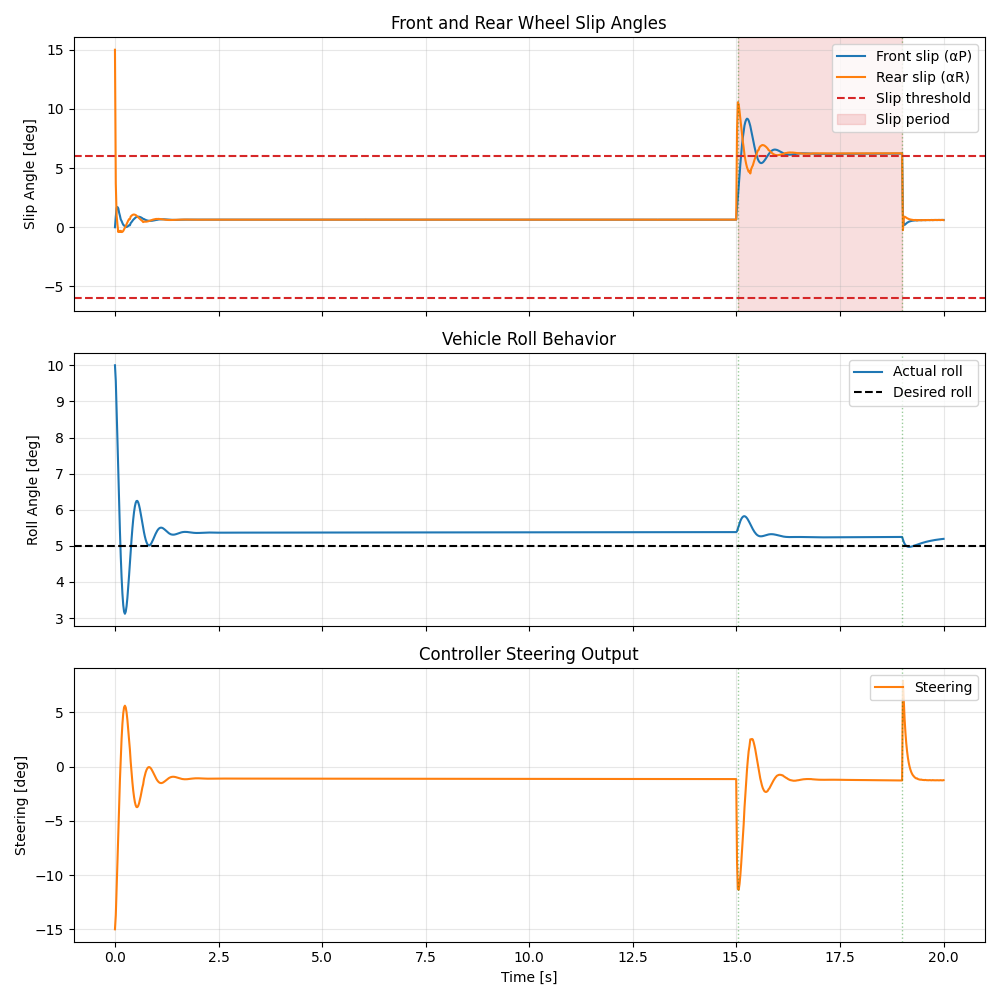

In [3]:
import numpy as np
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
me.init_vprinting()

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_interactions import ipyplot as iplt

import control as ct
from control.matlab import *
import scipy.linalg

# %%
# Specify the equations of motion
# -------------------------------
#
# The model is constructed using several constant parameters:
#
# - :math:`h`: distance mass center is from the ground contact line
# - :math:`a`: longitudinal distance of the mass center from the rear contact
# - :math:`b`: wheelbase length
# - :math:`g`: acceleration due to gravity
# - :math:`m`: mass of bicycle and rider
# - :math:`I_1`: roll principle moment of inertia
# - :math:`I_2`: pitch principle moment of inertia
# - :math:`I_3`: yaw principle moment of inertia
h, a, b, g = sm.symbols('h a, b, g', real=True)
m, I1, I2, I3 = sm.symbols('m, I1, I2, I3', real=True)
CaP, CaR = sm.symbols('CaP, CaR', real=True)

q1, q2, q3, q4, q5 = me.dynamicsymbols('q1, q2, q3, q4, q5', real=True)
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1, u2, u3, u4, u5', real=True)
t = me.dynamicsymbols._t

q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3])
C_alpha = sm.Matrix([CaP, CaR])
r = sm.Matrix([q5, u5])
qd = q.diff(t)
qdd = qd.diff(t)

N, A, B, C = sm.symbols('N, A, B, C', cls=me.ReferenceFrame)
O, P, Q, R, S = sm.symbols('O, P, Q, R, S',  cls=me.Point)

A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)

bike_body = me.RigidBody('bike', S, B, m, IB)

alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom = sm.lambdify((q, u, r, p, CaP, CaR),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip = sm.lambdify((q, u, r, p, CaP, CaR), (alphaP, alphaR))
Md_slip = kane.mass_matrix_full[-4:, -4:] # extract the bottom 4 right side rows and columns because the top left is FK
# gd = kane.forcing_full[-4:] # extract the last 4 entries because they are gd # idk whty but this didnt work so I got each term and made a matrix
gd_slip = sm.Matrix([kane.forcing_full[4], kane.forcing_full[5], kane.forcing_full[6], kane.forcing_full[7]])
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)

u2d = {u1: q1.diff(t), u2:q2.diff(t), u3: q3.diff(t), u4: q4.diff(t)}
gd_slip = gd_slip.xreplace(u2d)
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)


EOM_slip = Md_slip * qdd + gd_slip

dq4, dq4dot = sm.symbols('delta_q4 delta_q4dot')

xe_repl = {
    q1 : 0,
    q2 : 0,
    q3 : 0,
    q4 : 0,
    q5 : 0,
    q1.diff(t) : 5*sm.cos(q3),
    q2.diff(t) : 5*sm.sin(q3),
    q3.diff(t) : 0,
    q4.diff(t) : 0,
    q5.diff(t) : 0,
    q1.diff(t).diff(t) : 0,
    q2.diff(t).diff(t) : 0,
    q3.diff(t).diff(t) : 0,
    q4.diff(t).diff(t) : 0,
    q5.diff(t).diff(t) : 0,
 }

x = sm.Matrix([
    q1,
    q2,
    q3,
    q4,
    q5,
    q1.diff(t),
    q2.diff(t),
    q3.diff(t),
    q4.diff(t),
    q5.diff(t),
    q1.diff(t).diff(t),
    q2.diff(t).diff(t),
    q3.diff(t).diff(t),
    q4.diff(t).diff(t),
    q5.diff(t).diff(t),
])

xe = sm.Matrix([
    0,
    0,
    0,
    0,
    0,
    5*sm.cos(q3),
    5*sm.sin(q3),
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
])


f_lin_slip = EOM_slip.subs(xe_repl) + EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe)
sm.trigsimp(f_lin_slip)

qdd_L = sm.Matrix([q1.diff(t).diff(t), q2.diff(t).diff(t), q3.diff(t).diff(t), q4.diff(t).diff(t)])
# Solve the system of equations for accelerationsI have more 
solutions = sm.solve(f_lin_slip, (qdd_L))
solutions
EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe), EOM_slip.subs(xe_repl), sm.trigsimp(f_lin_slip), solutions

########## Getting state space of my system #################

# Convert to equations
solutions_matrix = sm.Matrix([solutions[q] for q in qdd_L])

q1_ddot = solutions_matrix[0]
q2_ddot = solutions_matrix[1]
q3_ddot = solutions_matrix[2]
q4_ddot = solutions_matrix[3]

# State derivatives
state_derivative = sm.Matrix([q4.diff(t), q4_ddot]) # q3.diff(t), q3_ddot,

# Input vector
input_vector = sm.Matrix([q5])
x = sm.Matrix([q4, q4.diff(t)]) # where q5 is lean q3, q3.diff(t), 

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
A = state_derivative.jacobian(x)

# Compute B matrix: partial derivatives of state_derivative w.r.t. input
B = state_derivative.jacobian(input_vector)
B = -B

# Replace cos(q3) with 1 while preserving other cos terms
A = A.subs(sm.cos(q3), 1)
B = B.subs(sm.cos(q3), 1)

x0_lin = np.array([
    # 0.0,
    # 0.0,
    0.0,
    np.deg2rad(10.0),#lean
    # 4.0,# vel in
    0.0,
    0.0,
    # 0.0,
])

p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    # 3600.0,  # CaP
    # 3600.0,  # CaR
])

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
eval_A = sm.lambdify((p, CaP, CaR), A)
eval_B = sm.lambdify((p, CaP, CaR), B)

A_val = eval_A(p_vals, 3600, 3600)
B_val = eval_B(p_vals, 3600, 3600)

###################################### Define the cost matrices Q and R ####################################################
Q = np.diag([50, 5])  # Penalty on states same size as A ( theta and theta dot)
R = np.diag([1])        # Penalize steering (input) effort same size as B (delta and delta_dot) and square, and numerically singular

# Step 4: Solve the continuous-time algebraic Riccati equation (CARE) to get the optimal gain matrix K
# P is the solution to the Riccati equation
P = scipy.linalg.solve_continuous_are(A_val, B_val, Q, R)
# the LQR gains matrix
K = np.linalg.inv(R) @ B_val.T @ P
############################### Detect slip ###############################
# set up a dictionary 
def create_slip_monitor():
    """Track slip"""
    monitor = {
        'last_alphaP': None,
        'last_alphaR': None,
        'slip_detected': False,
        'slip_start_times': [],
        'slip_end_times': [],
        'active_slip_periods': [],
        'slip_duration': 2.0
    }
    return monitor
# Initialize monitor
monitor = create_slip_monitor()


######################### LQR for asphault ##############################

import numpy as np
import scipy.linalg

# Define parameters for asphalt and ice
CaP_asphalt, CaR_asphalt = 3600.0, 3600.0  # High grip (asphalt)
CaP_ice, CaR_ice = 360.0, 360.0            # Low grip (ice)

# Compute controllers for both conditions
# Compute controllers for both conditions
def compute_controllers(p, Q, R):
    """Compute LQR controllers for both asphalt and ice conditions"""
    # Asphalt controller
    A_asphalt = eval_A(p, CaP_asphalt, CaR_asphalt)
    B_asphalt = eval_B(p, CaP_asphalt, CaR_asphalt)
    
    # Ice controller
    A_ice = eval_A(p, CaP_ice, CaR_ice)
    B_ice = eval_B(p, CaP_ice, CaR_ice)
    
    # Solve Riccati equations
    P_asphalt = scipy.linalg.solve_continuous_are(A_asphalt, B_asphalt, Q, R)
    P_ice = scipy.linalg.solve_continuous_are(A_ice, B_ice, Q, R)
    
    # Compute gain matrices
    K_asphalt = np.linalg.inv(R) @ B_asphalt.T @ P_asphalt
    K_ice = np.linalg.inv(R) @ B_ice.T @ P_ice
    
    return K_asphalt, K_ice

# Pre-compute both controllers
K_asphalt, K_ice = compute_controllers(p_vals, Q, R)
def control(t, q, u):
    """
    Slip-adaptive controller that:
    - Uses PD controller (identical to pure PD version) for first 2 seconds
    - Then switches to LQR when slip is detected
    """
    global monitor
    
    # Extract roll states
    theta = q[3]       # Roll angle (rad)
    theta_dot = u[3]    # Roll rate (rad/s)
    
    # Desired state (for LQR)
    x_des = np.array([np.deg2rad(theta_des), 0])
    x = np.array([theta, theta_dot])
    
    # Get current slip angles (using current CaP/CaR)
    current_CaP = 360.0 if monitor['slip_detected'] else 3600.0
    current_CaR = 360.0 if monitor['slip_detected'] else 3600.0
    alphaP, alphaR = eval_slip(q, u, [0, 0], p_vals, current_CaP, current_CaR)
    
    # Slip detection logic (identical to pure PD version)
    slip_condition = False
    if t > 2.0:  # Only detect slips after 2 seconds
        if np.abs(np.rad2deg(alphaP)) > 6 or np.abs(np.rad2deg(alphaR)) > 6:
            slip_condition = True
    
    # Update slip state (identical to pure PD version)
    if t > 2.0:
        if slip_condition:
            if not monitor['slip_detected']:
                monitor['slip_detected'] = True
                monitor['slip_start_time'] = t
                monitor['slip_start_times'].append(t)  
        elif monitor['slip_detected'] and (t - monitor['slip_start_time'] > monitor['slip_duration']):
            monitor['slip_detected'] = False
            monitor['slip_end_times'].append(t)
            monitor['active_slip_periods'].append((monitor['slip_start_time'], t))
    
    # Update last values
    monitor['last_alphaP'] = alphaP
    monitor['last_alphaR'] = alphaR
    
    # Controller selection
    if monitor['slip_detected'] and t > 2.0:
        # Use LQR when slip is detected
        K = K_ice
        delta = -K @ (x - x_des)
    else:
       # use PD to simulate bike with minimal control
        gain = 3.0
        delta = np.array([
            gain * (np.deg2rad(theta_des) - theta),  # P term (identical form)
            -gain * theta_dot                        # D term (identical form)
        ])
    
    return np.array([delta[0], 0.0])  # [steer_angle, steer_rate]

theta_des = 5
initial_speed = 7.0  # m/s
target_roll_angle = np.deg2rad(10)

# Create empty arrays to store slip angles and tire forces
alphaP_lqr_history = []
alphaR_lqr_history = []
FyP_lqr_history = []
FyR_lqr_history = []
time_lqr_history = []

control_lqr_history = []
control_lqr_times = []

def rhs_lqr(t, x, p):
    q = x[0:4]
    u = x[4:8]

    r = control(t, q, u)
    # Store control outputs with time stamps
    control_lqr_history.append(r)
    control_lqr_times.append(t)

    # Update CaP and CaR based on time
    if 15 <= t <= 19.0:
        CaP = 360.0  # Low friction (ice)
        CaR = 360.0
    else:
        CaP = 3600.0  # High friction (asphalt)
        CaR = 3600.0

    # Evaluate the equations of motion
    M, F = eval_eom(q, u, r, p, CaP, CaR)

    # Evaluate slip angles
    alphaP_val, alphaR_val = eval_slip(q, u, r, p, CaP, CaR)

    alphaP_lqr_history.append(alphaP_val)
    alphaR_lqr_history.append(alphaR_val)

    # Cap slip angles at 6 degrees
    alpha_max = np.deg2rad(6.0)
    alphaP_val = np.clip(alphaP_val, -alpha_max, alpha_max)
    alphaR_val = np.clip(alphaR_val, -alpha_max, alpha_max)

    # Calculate tire forces
    time_lqr_history.append(t)
    FyP = CaP * alphaP_val
    FyR = CaR * alphaR_val
    FyP_lqr_history.append(FyP)
    FyR_lqr_history.append(FyR)

    return np.linalg.solve(M, F.squeeze())


x0 = np.array([
    0.0,
    0.0,
    0.0,
    target_roll_angle,  # q4 [rad]
    initial_speed,  # u1 [m/s]
    0.0,
    0.0,
    0.0,
])


def roll_angle_event(t, x, p):
    """
    Event function to stop the solver if roll angle (theta) exceeds 60 or goes below -60 degrees.
    """
    roll_angle = np.rad2deg(x[3])  # x[3] is the roll angle (theta), converted to degrees
    max_angle = 30  # Upper and lower bounds in degrees
    
    # Return the difference between the roll angle and the bounds
    # The event is triggered when this value crosses zero
    return roll_angle**2 - max_angle**2  # Returns 0 when |roll_angle| == max_angle

# Set the event properties
roll_angle_event.terminal = True  # Stop the solver when the event is triggered
roll_angle_event.direction = 0    # Detect event when crossing from either direction (positive or negative)

t_eval = np.linspace(0, 20, 1000)  # 1000 evenly spaced points
solution_lqr = solve_ivp(rhs_lqr, (0.0, 20.0), x0, args=(p_vals,), events=roll_angle_event, t_eval=t_eval)


########### post process ###########
qs_lqr = solution_lqr.y[0:4]
us_lqr = solution_lqr.y[4:8]

# Convert stored values to numpy arrays
alphaP_lqr_arr = np.array(alphaP_lqr_history).squeeze()
alphaR_lqr_arr = np.array(alphaR_lqr_history).squeeze()
FyP_lqr_arr = np.array(FyP_lqr_history).squeeze()
FyR_lqr_arr = np.array(FyR_lqr_history).squeeze()

# Create time array for stored values
internal_lqr_times = np.array(time_lqr_history)

# First, extract delta values from control_history
delta_history = [cmd[0] for cmd in control_lqr_history]  # Get first element of each control output

# Convert stored values to numpy arrays
delta_arr = np.array(delta_history).squeeze()
time_arr = np.array(control_lqr_times)

# Create interpolation function for delta
from scipy.interpolate import interp1d
interp_delta = interp1d(time_arr, delta_arr, bounds_error=False, fill_value="extrapolate")
delta_plot = interp_delta(solution_lqr.t)

# Create interpolation functions
from scipy.interpolate import interp1d
interp_alphaP = interp1d(internal_lqr_times, alphaP_lqr_arr, bounds_error=False, fill_value="extrapolate")
interp_alphaR = interp1d(internal_lqr_times, alphaR_lqr_arr, bounds_error=False, fill_value="extrapolate")
interp_FyP = interp1d(internal_lqr_times, FyP_lqr_arr, bounds_error=False, fill_value="extrapolate")
interp_FyR = interp1d(internal_lqr_times, FyR_lqr_arr, bounds_error=False, fill_value="extrapolate")

# Get values at solution time points
alphaP_plot = interp_alphaP(solution_lqr.t)
alphaR_plot = interp_alphaR(solution_lqr.t)
FyP_plot = interp_FyP(solution_lqr.t)
FyR_plot = interp_FyR(solution_lqr.t)

# After simulation, check if we have data
if not control_lqr_history:
    raise RuntimeError("No control outputs were recorded during simulation")

# Create interpolators
control_arr = np.array(control_lqr_history).T
steering_interp = interp1d(control_lqr_times, control_arr[0], 
                          bounds_error=False, fill_value="extrapolate")

# Get steering angles at solution time points
steering_angles = steering_interp(solution_lqr.t)
steering_rates = np.zeros_like(steering_angles)  # u5 is always 0



# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True, layout='constrained')

# Custom colors
front_color = '#1f77b4'  # Blue for front
rear_color = '#ff7f0e'   # Orange for rear
slip_color = '#d62728'   # Red for slip threshold
steer_color = '#ff7f0e'  # Green for steering
roll_color = '#1f77b4'   # Purple for roll

# Plot 1: Combined Slip Angles (Front and Rear)
ax1.plot(solution_lqr.t, np.rad2deg(alphaP_plot), color=front_color, label='Front slip (αP)')
ax1.plot(solution_lqr.t, np.rad2deg(alphaR_plot), color=rear_color, label='Rear slip (αR)')
ax1.axhline(6, color=slip_color, linestyle='--', label='Slip threshold')
ax1.axhline(-6, color=slip_color, linestyle='--')

# Highlight slip periods
if len(monitor['active_slip_periods']) > 0:
    for start, end in monitor['active_slip_periods']:
        ax1.axvspan(start, end, color=slip_color, alpha=0.15, 
                   label='Slip period' if start == monitor['active_slip_periods'][0][0] else "")

ax1.set_ylabel('Slip Angle [deg]')
ax1.set_title('Front and Rear Wheel Slip Angles')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# Plot 2: Roll Angle
ax2.plot(solution_lqr.t, np.rad2deg(qs_lqr[3]), color=roll_color, label='Actual roll')
ax2.axhline(theta_des, color='k', linestyle='--', label='Desired roll')
ax2.set_ylabel('Roll Angle [deg]')
ax2.set_title('Vehicle Roll Behavior')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Plot 3: Steering Angle
ax3.plot(solution_lqr.t, np.rad2deg(delta_plot), color=steer_color, label='Steering')
ax3.set_ylabel('Steering [deg]')
ax3.set_xlabel('Time [s]')
ax3.set_title('Controller Steering Output')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper right')

# Mark slip detection moments on all plots
if len(monitor['slip_start_times']) > 0:
    for ax in [ax1, ax2, ax3]:
        for t in monitor['slip_start_times']:
            ax.axvline(t, color='green', linestyle=':', alpha=0.4, linewidth=1,
                      label='Slip detected' if t == monitor['slip_start_times'][0] else "")

plt.tight_layout()
plt.show()


/var/folders/xv/s21tw0zj3njb0tc6nb87t33r0000gn/T/ipykernel_68767/3923517218.py:392: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


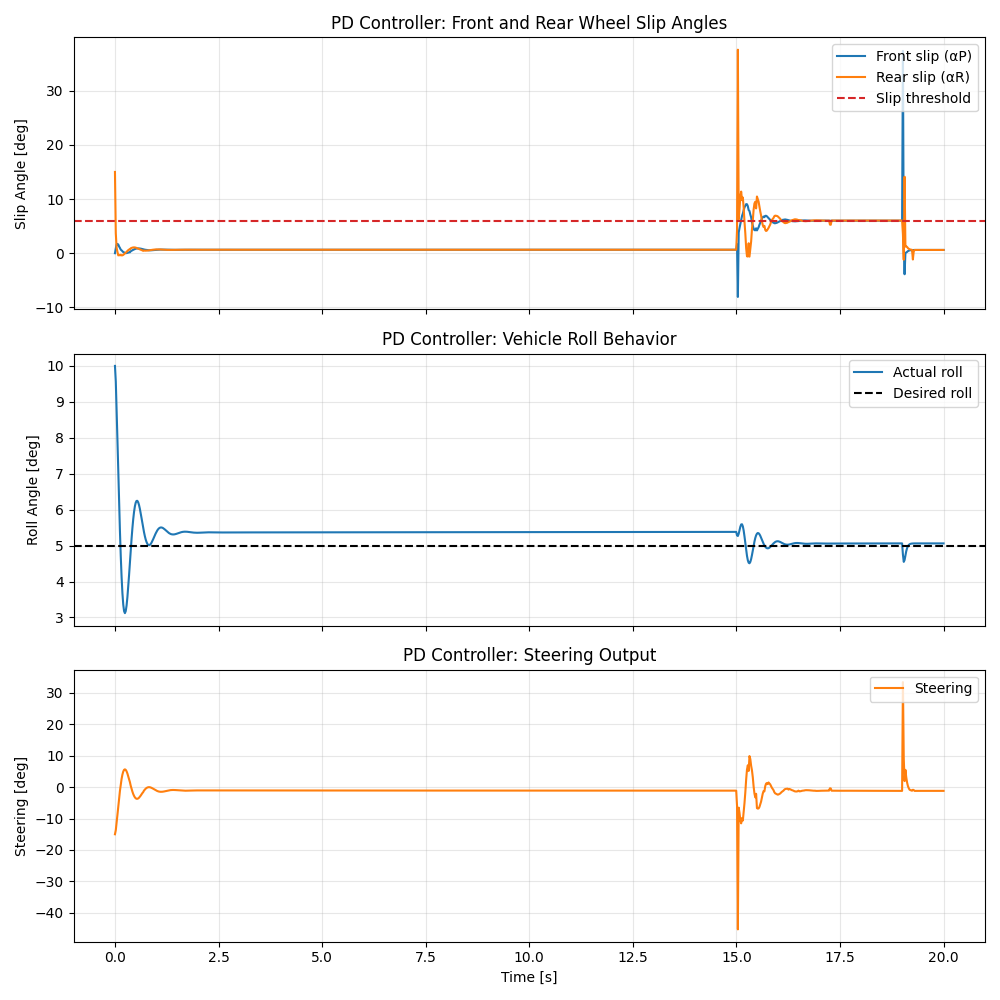

In [4]:
h, a, b, g = sm.symbols('h a, b, g', real=True)
m, I1, I2, I3 = sm.symbols('m, I1, I2, I3', real=True)
CaP, CaR = sm.symbols('CaP, CaR', real=True)

q1, q2, q3, q4, q5 = me.dynamicsymbols('q1, q2, q3, q4, q5', real=True)
u1, u2, u3, u4, u5 = me.dynamicsymbols('u1, u2, u3, u4, u5', real=True)
t = me.dynamicsymbols._t

q = sm.Matrix([q1, q2, q3, q4])
u = sm.Matrix([u1, u2, u3, u4])
p = sm.Matrix([h, a, b, g, m, I1, I2, I3])
C_alpha = sm.Matrix([CaP, CaR])
r = sm.Matrix([q5, u5])
qd = q.diff(t)
qdd = qd.diff(t)

N, A, B, C = sm.symbols('N, A, B, C', cls=me.ReferenceFrame)
O, P, Q, R, S = sm.symbols('O, P, Q, R, S',  cls=me.Point)

A.orient_axis(N, q3, N.z)
B.orient_axis(A, q4, A.x)
C.orient_axis(A, q5, A.z)

P.set_pos(O, q1*N.x + q2*N.y)
Q.set_pos(P, a*A.x)
R.set_pos(P, b*A.x)
S.set_pos(Q, h*B.z)

A.set_ang_vel(N, u3*N.z)
B.set_ang_vel(A, u4*A.x)
C.set_ang_vel(A, u5*A.z)

O.set_vel(N, 0)
P.set_vel(N, u1*N.x + u2*N.y)
Q.v2pt_theory(P, N, A)
R.v2pt_theory(P, N, A)
S.v2pt_theory(Q, N, B)

IB = me.Inertia.from_inertia_scalars(S, B, I1, I2, I3)

bike_body = me.RigidBody('bike', S, B, m, IB)

alphaP = sm.atan(P.vel(N).dot(A.y) / P.vel(N).dot(A.x))
alphaR = sm.atan(R.vel(N).dot(C.y) / R.vel(N).dot(C.x))

gravity = me.Force(S, -m*g*N.z)
rear_tire = me.Force(P, -CaP*alphaP*A.y)
front_tire = me.Force(R, -CaR*alphaR*C.y)

kane = me.KanesMethod(
    N,
    (q1, q2, q3, q4),
    (u1, u2, u3, u4),
    kd_eqs=(u1 - q1.diff(t),
            u2 - q2.diff(t),
            u3 - q3.diff(t),
            u4 - q4.diff(t),)
)

kane.kanes_equations(bodies=(bike_body,),
                     loads=(gravity, front_tire, rear_tire))

eval_eom = sm.lambdify((q, u, r, p, CaP, CaR),
                       (kane.mass_matrix_full, kane.forcing_full))

eval_slip = sm.lambdify((q, u, r, p, CaP, CaR), (alphaP, alphaR))
Md_slip = kane.mass_matrix_full[-4:, -4:] # extract the bottom 4 right side rows and columns because the top left is FK
# gd = kane.forcing_full[-4:] # extract the last 4 entries because they are gd # idk whty but this didnt work so I got each term and made a matrix
gd_slip = sm.Matrix([kane.forcing_full[4], kane.forcing_full[5], kane.forcing_full[6], kane.forcing_full[7]])
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)

u2d = {u1: q1.diff(t), u2:q2.diff(t), u3: q3.diff(t), u4: q4.diff(t)}
gd_slip = gd_slip.xreplace(u2d)
me.find_dynamicsymbols(Md_slip), me.find_dynamicsymbols(gd_slip)


EOM_slip = Md_slip * qdd + gd_slip

dq4, dq4dot = sm.symbols('delta_q4 delta_q4dot')

xe_repl = {
    q1 : 0,
    q2 : 0,
    q3 : 0,
    q4 : 0,
    q5 : 0,
    q1.diff(t) : 5*sm.cos(q3),
    q2.diff(t) : 5*sm.sin(q3),
    q3.diff(t) : 0,
    q4.diff(t) : 0,
    q5.diff(t) : 0,
    q1.diff(t).diff(t) : 0,
    q2.diff(t).diff(t) : 0,
    q3.diff(t).diff(t) : 0,
    q4.diff(t).diff(t) : 0,
    q5.diff(t).diff(t) : 0,
 }

x = sm.Matrix([
    q1,
    q2,
    q3,
    q4,
    q5,
    q1.diff(t),
    q2.diff(t),
    q3.diff(t),
    q4.diff(t),
    q5.diff(t),
    q1.diff(t).diff(t),
    q2.diff(t).diff(t),
    q3.diff(t).diff(t),
    q4.diff(t).diff(t),
    q5.diff(t).diff(t),
])

xe = sm.Matrix([
    0,
    0,
    0,
    0,
    0,
    5*sm.cos(q3),
    5*sm.sin(q3),
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
])


f_lin_slip = EOM_slip.subs(xe_repl) + EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe)
sm.trigsimp(f_lin_slip)

qdd_L = sm.Matrix([q1.diff(t).diff(t), q2.diff(t).diff(t), q3.diff(t).diff(t), q4.diff(t).diff(t)])
# Solve the system of equations for accelerationsI have more 
solutions = sm.solve(f_lin_slip, (qdd_L))
solutions
EOM_slip.jacobian(x).subs(xe_repl) @ (x - xe), EOM_slip.subs(xe_repl), sm.trigsimp(f_lin_slip), solutions

########## Getting state space of my system #################

# Convert to equations
solutions_matrix = sm.Matrix([solutions[q] for q in qdd_L])

q1_ddot = solutions_matrix[0]
q2_ddot = solutions_matrix[1]
q3_ddot = solutions_matrix[2]
q4_ddot = solutions_matrix[3]

# State derivatives
state_derivative = sm.Matrix([q4.diff(t), q4_ddot]) # q3.diff(t), q3_ddot,

# Input vector
input_vector = sm.Matrix([q5])
x = sm.Matrix([q4, q4.diff(t)]) # where q5 is lean q3, q3.diff(t), 

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
A = state_derivative.jacobian(x)

# Compute B matrix: partial derivatives of state_derivative w.r.t. input
B = state_derivative.jacobian(input_vector)
B = -B

# Replace cos(q3) with 1 while preserving other cos terms
A = A.subs(sm.cos(q3), 1)
B = B.subs(sm.cos(q3), 1)

x0_lin = np.array([
    # 0.0,
    # 0.0,
    0.0,
    np.deg2rad(10.0),#lean
    # 4.0,# vel in
    0.0,
    0.0,
    # 0.0,
])

p_vals = np.array([
    1.0,  # h [m]
    0.5,  # a [m]
    1.0,  # b [m]
    9.81,  # g [m/s^2]
    87.0,  # m [kg]
    9.2,  # I1 [kg m^2]
    11.0,  # I2 [kg m^2]
    2.8,  # I3 [kg m^2]
    # 3600.0,  # CaP
    # 3600.0,  # CaR
])

# Compute A matrix: partial derivatives of state_derivative w.r.t. state
eval_A = sm.lambdify((p, CaP, CaR), A)
eval_B = sm.lambdify((p, CaP, CaR), B)

A_val = eval_A(p_vals, 3600, 3600)
B_val = eval_B(p_vals, 3600, 3600)

###################################### Define the cost matrices Q and R ####################################################
Q = np.diag([50, 5])  # Penalty on states same size as A ( theta and theta dot)
R = np.diag([1])        # Penalize steering (input) effort same size as B (delta and delta_dot) and square, and numerically singular

# Step 4: Solve the continuous-time algebraic Riccati equation (CARE) to get the optimal gain matrix K
# P is the solution to the Riccati equation
P = scipy.linalg.solve_continuous_are(A_val, B_val, Q, R)
# the LQR gains matrix
# K = np.linalg.inv(R) @ B_val.T @ P

############################## Detect slip ###############################
# set up a dictionary 
def create_slip_monitor():
    """Track slip"""
    monitor = {
        'last_alphaP': None,
        'last_alphaR': None,
        'slip_detected': False,
        'slip_start_times': [],
        'slip_end_times': [],
        'active_slip_periods': [],
        'slip_duration': 2.0
    }
    return monitor
# Initialize monitor
monitor = create_slip_monitor()

import numpy as np
import scipy.linalg

def control(t, q, u):
    """
    Slip-adaptive PD controller with LQR-style control flow:
    - Uses normal PD gains for first 2 seconds
    - Then switches to higher PD gains when slip is detected
    """
    global monitor
    
    # Extract roll states
    theta = q[3]       # Roll angle (rad)
    theta_dot = u[3]    # Roll rate (rad/s)
    
    # PD gains
    normal_gain = 3.0
    high_gain = 20.0
    
    # Get current slip angles (using current CaP/CaR)
    current_CaP = 360.0 if monitor['slip_detected'] else 3600.0
    current_CaR = 360.0 if monitor['slip_detected'] else 3600.0
    alphaP, alphaR = eval_slip(q, u, [0, 0], p_vals, current_CaP, current_CaR)
    
    # Slip detection logic (but don't activate for first 2 seconds)
    slip_condition = False
    if t > 2.0:  # Only detect slips after 2 seconds
        # Check if exceeding ±6° bounds
        if np.abs(np.rad2deg(alphaP)) > 6 or np.abs(np.rad2deg(alphaR)) > 6:
            slip_condition = True
    
    # Update slip state (only after 2 seconds)
    if t > 2.0:
        if slip_condition:
            if not monitor['slip_detected']:
                monitor['slip_detected'] = True
                monitor['slip_start_time'] = t
                monitor['slip_start_times'].append(t)  
        elif monitor['slip_detected'] and (t - monitor['slip_start_time'] > monitor['slip_duration']):
            monitor['slip_detected'] = False
            monitor['slip_end_times'].append(t)
            monitor['active_slip_periods'].append((monitor['slip_start_time'], t))
    
    # Update last values
    monitor['last_alphaP'] = alphaP
    monitor['last_alphaR'] = alphaR
    
    # Controller selection - structured like LQR version
    if monitor['slip_detected'] and t > 2.0:
        # High-gain PD when slip is detected
        delta = np.array([
            high_gain * (np.deg2rad(theta_des) - theta),
            -high_gain * theta_dot
        ])
    else:
        # Normal-gain PD otherwise
        delta = np.array([
            normal_gain * (np.deg2rad(theta_des) - theta),
            -normal_gain * theta_dot
        ])
    
    return np.array([delta[0], 0.0])  # [steer_angle, steer_rate]

theta_des = 5
initial_speed = 7.0  # m/s
target_roll_angle = np.deg2rad(10)

# Update all history arrays with _pd suffix
alphaP_pd_history = []
alphaR_pd_history = []
FyP_pd_history = []
FyR_pd_history = []
time_pd_history = []

control_pd_history = []
control_pd_times = []

def rhs_pd(t, x, p):
    q = x[0:4]
    u = x[4:8]

    r = control(t, q, u)
    control_pd_history.append(r)
    control_pd_times.append(t)

    if 15 <= t <= 19.0:
        CaP = 360.0
        CaR = 360.0
    else:
        CaP = 3600.0
        CaR = 3600.0

    M, F = eval_eom(q, u, r, p, CaP, CaR)
    alphaP_val, alphaR_val = eval_slip(q, u, r, p, CaP, CaR)

    alphaP_pd_history.append(alphaP_val)
    alphaR_pd_history.append(alphaR_val)

    alpha_max = np.deg2rad(6.0)
    alphaP_val = np.clip(alphaP_val, -alpha_max, alpha_max)
    alphaR_val = np.clip(alphaR_val, -alpha_max, alpha_max)

    time_pd_history.append(t)
    FyP = CaP * alphaP_val
    FyR = CaR * alphaR_val
    FyP_pd_history.append(FyP)
    FyR_pd_history.append(FyR)

    return np.linalg.solve(M, F.squeeze())

# Solve with PD controller
solution_pd = solve_ivp(rhs_pd, (0.0, 20.0), x0, args=(p_vals,), events=roll_angle_event, t_eval=t_eval)

# Post-processing with _pd suffix
qs_pd = solution_pd.y[0:4]
us_pd = solution_pd.y[4:8]

alphaP_pd_arr = np.array(alphaP_pd_history).squeeze()
alphaR_pd_arr = np.array(alphaR_pd_history).squeeze()
FyP_pd_arr = np.array(FyP_pd_history).squeeze()
FyR_pd_arr = np.array(FyR_pd_history).squeeze()

# Create interpolators
interp_delta_pd = interp1d(control_pd_times, np.array([cmd[0] for cmd in control_pd_history]), 
                          bounds_error=False, fill_value="extrapolate")
interp_alphaP_pd = interp1d(np.array(time_pd_history), alphaP_pd_arr, bounds_error=False, fill_value="extrapolate")
interp_alphaR_pd = interp1d(np.array(time_pd_history), alphaR_pd_arr, bounds_error=False, fill_value="extrapolate")

# Get interpolated values
delta_pd_plot = interp_delta_pd(solution_pd.t)
alphaP_pd_plot = interp_alphaP_pd(solution_pd.t)
alphaR_pd_plot = interp_alphaR_pd(solution_pd.t)

# Create figure with PD-specific titles
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True, layout='constrained')

# Plot 1: Slip Angles
ax1.plot(solution_pd.t, np.rad2deg(alphaP_pd_plot), color='#1f77b4', label='Front slip (αP)')
ax1.plot(solution_pd.t, np.rad2deg(alphaR_pd_plot), color='#ff7f0e', label='Rear slip (αR)')
ax1.axhline(6, color='#d62728', linestyle='--', label='Slip threshold')
ax1.set_ylabel('Slip Angle [deg]')
ax1.set_title('PD Controller: Front and Rear Wheel Slip Angles')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# Plot 2: Roll Angle
ax2.plot(solution_pd.t, np.rad2deg(qs_pd[3]), color='#1f77b4', label='Actual roll')
ax2.axhline(theta_des, color='k', linestyle='--', label='Desired roll')
ax2.set_ylabel('Roll Angle [deg]')
ax2.set_title('PD Controller: Vehicle Roll Behavior')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Plot 3: Steering Angle
ax3.plot(solution_pd.t, np.rad2deg(delta_pd_plot), color='#ff7f0e', label='Steering')
ax3.set_ylabel('Steering [deg]')
ax3.set_xlabel('Time [s]')
ax3.set_title('PD Controller: Steering Output')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()

/var/folders/xv/s21tw0zj3njb0tc6nb87t33r0000gn/T/ipykernel_68767/1221003123.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


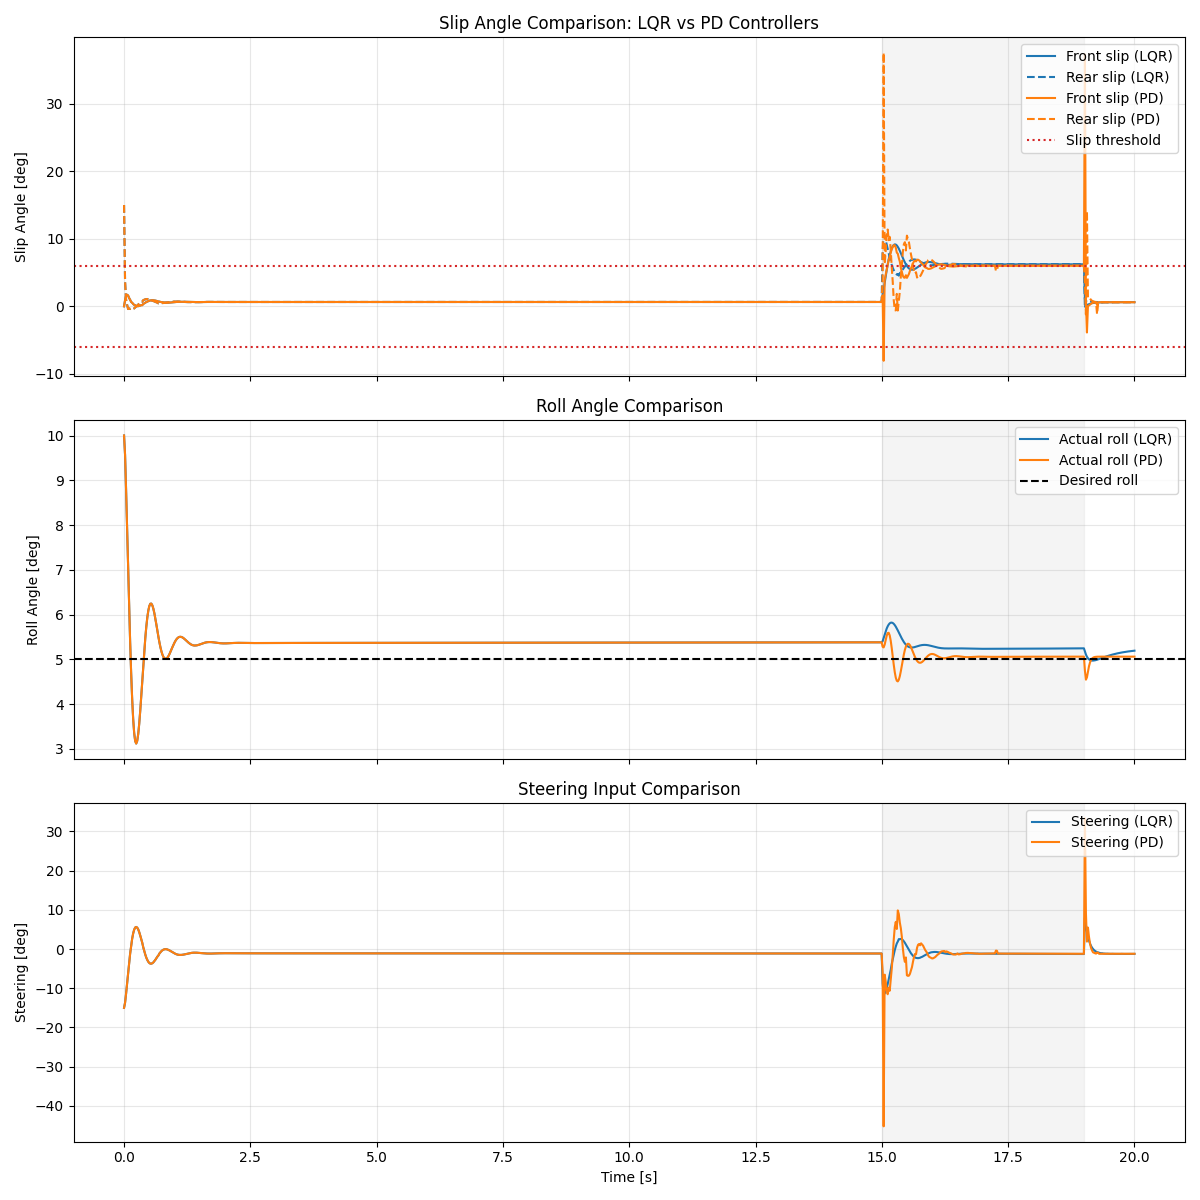

In [5]:
# Create the comparison plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True, layout='constrained')

# Colors and styles - swapped to match your request
lqr_color = '#1f77b4'   # Blue for LQR
pd_color = '#ff7f0e'    # Orange for PD
slip_color = '#d62728'  # Red for slip threshold
highlight_color = '#cccccc'  # Grey for slip highlights

# Plot 1: Slip Angles Comparison
ax1.plot(solution_lqr.t, np.rad2deg(alphaP_plot), color=lqr_color, linestyle='-', label='Front slip (LQR)')
ax1.plot(solution_lqr.t, np.rad2deg(alphaR_plot), color=lqr_color, linestyle='--', label='Rear slip (LQR)')
ax1.plot(solution_pd.t, np.rad2deg(alphaP_pd_plot), color=pd_color, linestyle='-', label='Front slip (PD)')
ax1.plot(solution_pd.t, np.rad2deg(alphaR_pd_plot), color=pd_color, linestyle='--', label='Rear slip (PD)')
ax1.axhline(6, color=slip_color, linestyle=':', label='Slip threshold')
ax1.axhline(-6, color=slip_color, linestyle=':')
ax1.set_ylabel('Slip Angle [deg]')
ax1.set_title('Slip Angle Comparison: LQR vs PD Controllers')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# Plot 2: Roll Angle Comparison
ax2.plot(solution_lqr.t, np.rad2deg(qs_lqr[3]), color=lqr_color, label='Actual roll (LQR)')
ax2.plot(solution_pd.t, np.rad2deg(qs_pd[3]), color=pd_color, label='Actual roll (PD)')
ax2.axhline(theta_des, color='k', linestyle='--', label='Desired roll')
ax2.set_ylabel('Roll Angle [deg]')
ax2.set_title('Roll Angle Comparison')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Plot 3: Steering Angle Comparison
ax3.plot(solution_lqr.t, np.rad2deg(delta_plot), color=lqr_color, label='Steering (LQR)')
ax3.plot(solution_pd.t, np.rad2deg(delta_pd_plot), color=pd_color, label='Steering (PD)')
ax3.set_ylabel('Steering [deg]')
ax3.set_xlabel('Time [s]')
ax3.set_title('Steering Input Comparison')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper right')

# Highlight fixed period from 15 to 19 seconds on all plots
def highlight_slips(ax, alpha=0.2):
    ax.axvspan(15, 19, color=highlight_color, alpha=alpha, label='Ice conditions')
    
# Apply highlights to all three plots
for ax in [ax1, ax2, ax3]:
    highlight_slips(ax)


plt.tight_layout()
plt.show()